#Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from yellowbrick.target import FeatureCorrelation

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



Pre-Processing

Data loading

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
df_houses = pd.read_csv('/content/drive/MyDrive/Projetos/PROJETO SEJA UM DATA SCIENTIST/Project Cyclic/kc_house_data.csv')

In [4]:
df_houses.head()

id             date      price  ...     long  sqft_living15  sqft_lot15
0  7129300520  20141013T000000 221900.000  ... -122.257           1340        5650
1  6414100192  20141209T000000 538000.000  ... -122.319           1690        7639
2  5631500400  20150225T000000 180000.000  ... -122.233           2720        8062
3  2487200875  20141209T000000 604000.000  ... -122.393           1360        5000
4  1954400510  20150218T000000 510000.000  ... -122.045           1800        7503

[5 rows x 21 columns]

In [5]:
df_houses.describe()

id       price  bedrooms  ...      long  sqft_living15  sqft_lot15
count      21613.000   21613.000 21613.000  ... 21613.000      21613.000   21613.000
mean  4580301520.865  540088.142     3.371  ...  -122.214       1986.552   12768.456
std   2876565571.312  367127.196     0.930  ...     0.141        685.391   27304.180
min      1000102.000   75000.000     0.000  ...  -122.519        399.000     651.000
25%   2123049194.000  321950.000     3.000  ...  -122.328       1490.000    5100.000
50%   3904930410.000  450000.000     3.000  ...  -122.230       1840.000    7620.000
75%   7308900445.000  645000.000     4.000  ...  -122.125       2360.000   10083.000
max   9900000190.000 7700000.000    33.000  ...  -121.315       6210.000  871200.000

[8 rows x 20 columns]

In [6]:
df_houses.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [7]:
df_houses.drop(['sqft_living15', 'sqft_lot15', 'id', 'date'], axis=1, inplace=True)

In [8]:
df_houses['price'].max() , df_houses['price'].min()

(7700000.0, 75000.0)

In [9]:
np.unique(df_houses['bedrooms'], return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 33]),
 array([  13,  199, 2760, 9824, 6882, 1601,  272,   38,   13,    6,    3,
           1,    1]))

Visualização dos dados

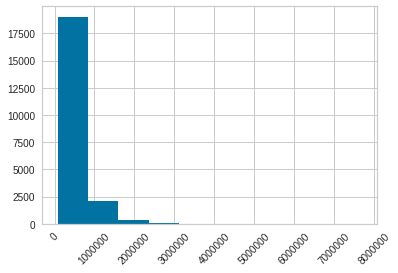

In [10]:

plt.hist(x= df_houses['price']);
plt.ticklabel_format(style='plain')
plt.xticks(rotation=45)
plt.show()

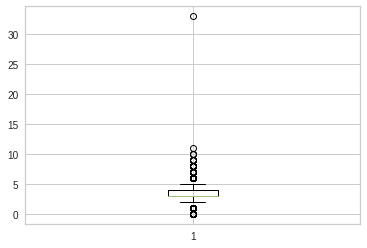

In [11]:
plt.boxplot(np.array(df_houses['bedrooms']));

In [12]:
np.unique(df_houses['bedrooms'], return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 33]),
 array([  13,  199, 2760, 9824, 6882, 1601,  272,   38,   13,    6,    3,
           1,    1]))

In [13]:
graph = px.scatter_matrix(df_houses, dimensions=['price', 'bedrooms','bathrooms', 'floors'], color='price')
graph.show()

Testar algumas hipóteses

In [14]:
#Compras casas com o preço abaixo da média.
df_houses[df_houses['price'] < df_houses['price'].mean()]

price  bedrooms  bathrooms  ...  zipcode    lat     long
0     221900.000         3      1.000  ...    98178 47.511 -122.257
1     538000.000         3      2.250  ...    98125 47.721 -122.319
2     180000.000         2      1.000  ...    98028 47.738 -122.233
4     510000.000         3      2.000  ...    98074 47.617 -122.045
6     257500.000         3      2.250  ...    98003 47.310 -122.327
...          ...       ...        ...  ...      ...    ...      ...
21608 360000.000         3      2.500  ...    98103 47.699 -122.346
21609 400000.000         4      2.500  ...    98146 47.511 -122.362
21610 402101.000         2      0.750  ...    98144 47.594 -122.299
21611 400000.000         3      2.500  ...    98027 47.535 -122.069
21612 325000.000         2      0.750  ...    98144 47.594 -122.299

[13694 rows x 17 columns]

In [15]:
df_houses_region = df_houses[['price','zipcode']].groupby('zipcode').mean().reset_index()
df_houses_region

zipcode       price
0     98001  280804.691
1     98002  234284.035
2     98003  294111.279
3     98004 1355927.082
4     98005  810164.875
..      ...         ...
65    98177  676185.392
66    98178  310612.756
67    98188  289078.346
68    98198  302878.882
69    98199  791820.808

[70 rows x 2 columns]

In [16]:
result = pd.DataFrame()
for dados in df_houses_region.values:
  a = df_houses[(df_houses['zipcode'] == int(dados[0])) & (df_houses['price'] < dados[1])]
  result = result.append(a.loc[a['price'].isin([a['price'].min()])],ignore_index=True)
result



price  bedrooms  bathrooms  ...  zipcode    lat     long
0  100000.000         2      1.000  ...    98001 47.300 -122.269
1  100000.000         2      1.000  ...    98001 47.278 -122.252
2   95000.000         1      0.750  ...    98002 47.305 -122.215
3  128000.000         3      1.000  ...    98003 47.343 -122.309
4  425000.000         4      1.750  ...    98004 47.598 -122.194
..        ...       ...        ...  ...      ...    ...      ...
69  90000.000         2      1.000  ...    98178 47.485 -122.251
70 110000.000         2      1.000  ...    98188 47.452 -122.286
71  95000.000         2      1.000  ...    98198 47.407 -122.294
72  95000.000         2      1.000  ...    98198 47.386 -122.307
73 323000.000         2      1.000  ...    98199 47.648 -122.397

[74 rows x 17 columns]

Para a primeira parte, levei em consideração as casas de valor mais baixo por região para poder comprar e revender a um preço mais próximo a média.

PARTE 2

---



In [17]:
graph = px.scatter_matrix(df_houses, dimensions=['price', 'sqft_lot','sqft_living'], color='price')
graph.show()

In [18]:
graph = px.scatter_matrix(df_houses, dimensions=['price', 'waterfront','condition'], color='price')
graph.show()

In [19]:
graph = px.scatter_matrix(df_houses, dimensions=['price', 'sqft_above','sqft_basement', 'zipcode'], color='price')
graph.show()

In [20]:
graph = px.scatter_matrix(df_houses, dimensions=['price', 'yr_built','yr_renovated','view'], color='price')
graph.show()

In [21]:
df_houses[df_houses['yr_renovated'] > 0]['price'].mean()

760379.0295404814

In [22]:
df_houses[df_houses['yr_renovated'] == 0]['price'].mean()

530360.8181554665

Após as análises dos gráficos, selecionei as features que para mim tem mais valor para uma análise. São elas, bedrooms/bathrooms/sqft_living/condition/zipcode/yr_built e sqft_above. Essas 5 features mais movimentou os preços das casas.

In [23]:
features_importance = pd.DataFrame()
features_importance = df_houses.drop(['view','grade','sqft_basement','yr_built'], axis=1)

In [24]:
features_importance

price  bedrooms  bathrooms  ...  zipcode    lat     long
0     221900.000         3      1.000  ...    98178 47.511 -122.257
1     538000.000         3      2.250  ...    98125 47.721 -122.319
2     180000.000         2      1.000  ...    98028 47.738 -122.233
3     604000.000         4      3.000  ...    98136 47.521 -122.393
4     510000.000         3      2.000  ...    98074 47.617 -122.045
...          ...       ...        ...  ...      ...    ...      ...
21608 360000.000         3      2.500  ...    98103 47.699 -122.346
21609 400000.000         4      2.500  ...    98146 47.511 -122.362
21610 402101.000         2      0.750  ...    98144 47.594 -122.299
21611 400000.000         3      2.500  ...    98027 47.535 -122.069
21612 325000.000         2      0.750  ...    98144 47.594 -122.299

[21613 rows x 13 columns]

In [25]:
features_importance['price'].mean()

540088.1417665294

In [26]:
 buy_house = features_importance[(features_importance['bedrooms'] > 3) & (features_importance['bedrooms']<= 7) & (features_importance['price'] < features_importance['price'].mean())
  & (features_importance['condition'] > 2) & (features_importance['yr_renovated'] == 0) ]

 buy_house

price  bedrooms  bathrooms  ...  zipcode    lat     long
14    530000.000         5      2.000  ...    98107 47.670 -122.394
17    485000.000         4      1.000  ...    98103 47.665 -122.343
20    385000.000         4      1.750  ...    98133 47.703 -122.341
22    285000.000         5      2.500  ...    98092 47.327 -122.169
34    322500.000         4      2.750  ...    98058 47.428 -122.157
...          ...       ...        ...  ...      ...    ...      ...
21562 422000.000         4      2.500  ...    98030 47.385 -122.186
21563 337000.000         4      2.500  ...    98038 47.362 -122.041
21565 341780.000         4      2.750  ...    98001 47.351 -122.291
21594 350000.000         4      2.750  ...    98042 47.375 -122.107
21609 400000.000         4      2.500  ...    98146 47.511 -122.362

[3974 rows x 13 columns]

Foi notado que, ao reformar uma casa, o preço médio sobe aproximadamente 230 Mil. Sendo assim, Irei comprar casas que não foram renovadas e com um preço abaixo da media - 230 Mil para conseguir máximar os lucros.

In [27]:
buy_house[buy_house['price'] < (buy_house['price'].mean() - 230000)]

price  bedrooms  bathrooms  ...  zipcode    lat     long
5639  100000.000         4      1.000  ...    98055 47.490 -122.203
13519 135000.000         4      1.000  ...    98146 47.501 -122.351
14224 142500.000         4      0.750  ...    98166 47.476 -122.337
15810 133000.000         5      2.000  ...    98118 47.519 -122.266
16367 139000.000         4      1.500  ...    98030 47.374 -122.188
18262 148900.000         4      1.750  ...    98002 47.325 -122.208

[6 rows x 13 columns]

Fechando a PARTE 2 com a compra de 6 casas com possível 400% de lucro no final.

In [28]:
def graph(y_test, predict):
  fig, ax = plt.subplots(figsize=(10,10))
  ax.scatter(y_test, predict)
  ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], lw=3, color='r')
  ax.set_xlabel('measured')
  ax.set_ylabel('predicted')
  plt.ticklabel_format(style='plain', axis='x')
  plt.ticklabel_format(style='plain', axis='y')

In [29]:
def regression_linear_function(X_train, X_test, y_train, y_test):
  linear_regression = LinearRegression()
  linear_regression.fit(X_train,y_train)
  predict = linear_regression.predict(X_test)
  abs_error = mean_absolute_error(y_test,predict)
  score = linear_regression.score(X_test,y_test)
  return abs_error, predict, score

In [30]:
def svr_function(X_train, X_test, y_train, y_test, stand_scaler):
  svr = SVR()
  svr.fit(X_train,y_train.ravel())
  predict = svr.predict(X_test)
  abs_error = mean_absolute_error(stand_scaler.inverse_transform(y_test),stand_scaler.inverse_transform(predict))
  score = svr.score(X_test,y_test)
  return abs_error, predict, score

In [31]:
def random_forest_function(X_train, X_test, y_train, y_test, stand_scaler = None):
  random_forest = RandomForestRegressor()
  
  random_forest.fit(X_train,y_train)
  predict = random_forest.predict(X_test)
  if stand_scaler == None:
    abs_error = mean_absolute_error(y_test,predict)
  else:
    abs_error = mean_absolute_error(stand_scaler.inverse_transform(y_test),stand_scaler.inverse_transform(predict))
  score = random_forest.score(X_test,y_test)
  return abs_error, predict, score

In [32]:
def neural_network(iter,A,B, X_train, X_test, y_train, y_test, stand_scaler):
  model = MLPRegressor(max_iter=iter,hidden_layer_sizes=(A, B))
  predict = model.fit(X_train, y_train.ravel()).predict(X_test)
  abs_error = mean_absolute_error(stand_scaler.inverse_transform(y_test),stand_scaler.inverse_transform(predict))
  score = model.score(X_test, y_test)
  return abs_error, predict, score

In [33]:
def split(X,y, size, state):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=size, random_state=state)
  return X_train, X_test, y_train, y_test

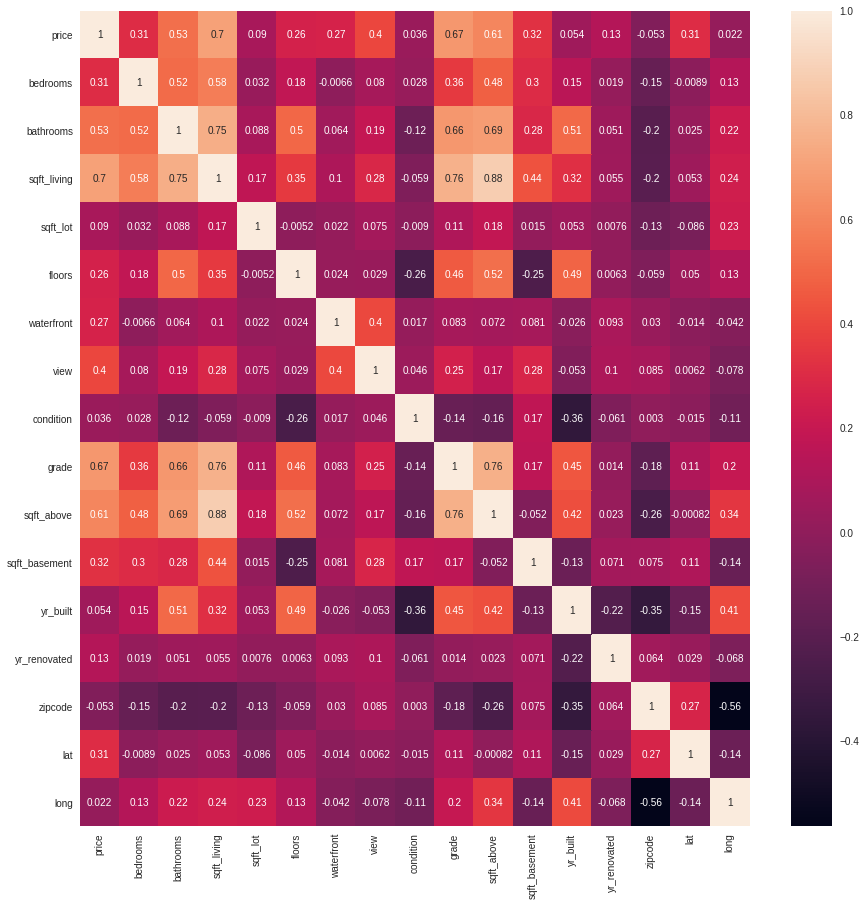

In [34]:
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(df_houses.corr(), annot = True)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.



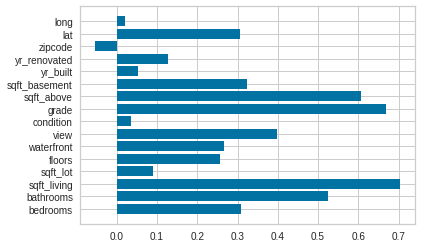

In [35]:
grafico = FeatureCorrelation(labels = df_houses.columns[1:])
grafico.fit(df_houses.iloc[:,1:len(df_houses.columns)].values, df_houses.iloc[:,0])
grafico;

In [36]:
X = df_houses.iloc[:, 1:len(df_houses.columns)]
y = df_houses.iloc[:, 0]

In [37]:
a = df_houses.corr()['price'].values
idx = []
for i,v in enumerate(a):
  if (abs(v) > 0.5):
    print('Feature: %0d, Score: %.5f' % (i,v))
    idx.append(i)

Feature: 0, Score: 1.00000
Feature: 2, Score: 0.52514
Feature: 3, Score: 0.70204
Feature: 9, Score: 0.66743
Feature: 10, Score: 0.60557


In [38]:
linear_regression = LinearRegression()

In [39]:
linear_regression.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [40]:
importance = linear_regression.coef_

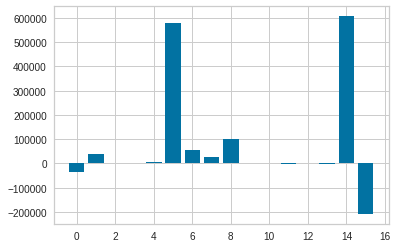

In [41]:
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [42]:
idx = [0]
for i,v in enumerate(importance):
  if v>= 100:
    print('Feature: %0d, Score: %.5f' % (i,v))
    idx.append(i)

	  

Feature: 1, Score: 40998.74995
Feature: 2, Score: 114.57339
Feature: 4, Score: 4890.19545
Feature: 5, Score: 578959.82680
Feature: 6, Score: 54862.36463
Feature: 7, Score: 25626.75606
Feature: 8, Score: 99889.28556
Feature: 14, Score: 607247.00922


In [43]:
idx

[0, 1, 2, 4, 5, 6, 7, 8, 14]

In [44]:
df_test = df_houses.iloc[:, idx]

In [45]:
df_test

price  bedrooms  bathrooms  ...  view  condition  zipcode
0     221900.000         3      1.000  ...     0          3    98178
1     538000.000         3      2.250  ...     0          3    98125
2     180000.000         2      1.000  ...     0          3    98028
3     604000.000         4      3.000  ...     0          5    98136
4     510000.000         3      2.000  ...     0          3    98074
...          ...       ...        ...  ...   ...        ...      ...
21608 360000.000         3      2.500  ...     0          3    98103
21609 400000.000         4      2.500  ...     0          3    98146
21610 402101.000         2      0.750  ...     0          3    98144
21611 400000.000         3      2.500  ...     0          3    98027
21612 325000.000         2      0.750  ...     0          3    98144

[21613 rows x 9 columns]

In [46]:
X_new = df_test.iloc[:,1:len(df_test)]
y_new = df_test.iloc[:,0]
print(X_new)
print(y_new)


       bedrooms  bathrooms  sqft_lot  ...  view  condition  zipcode
0             3      1.000      5650  ...     0          3    98178
1             3      2.250      7242  ...     0          3    98125
2             2      1.000     10000  ...     0          3    98028
3             4      3.000      5000  ...     0          5    98136
4             3      2.000      8080  ...     0          3    98074
...         ...        ...       ...  ...   ...        ...      ...
21608         3      2.500      1131  ...     0          3    98103
21609         4      2.500      5813  ...     0          3    98146
21610         2      0.750      1350  ...     0          3    98144
21611         3      2.500      2388  ...     0          3    98027
21612         2      0.750      1076  ...     0          3    98144

[21613 rows x 8 columns]
0       221900.000
1       538000.000
2       180000.000
3       604000.000
4       510000.000
           ...    
21608   360000.000
21609   400000.000
21610 

192502.11655245812
0.4064518024961474


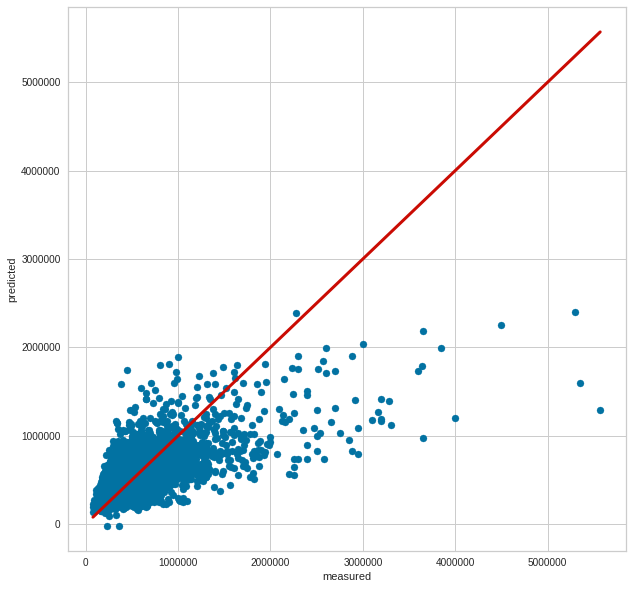

In [47]:
X_train, X_test, y_train, y_test = split(X_new,y_new, 0.25, 42)
error, predict, score = regression_linear_function(X_train, X_test, y_train, y_test)
print(error)
print(score)
graph(y_test, predict)

In [48]:
X_train, X_test, y_train, y_test = split(X,y, 0.25, 42)
poly = PolynomialFeatures(degree=2)

In [49]:
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.fit_transform(X_test)


105130.39478863336
0.7997524499213977


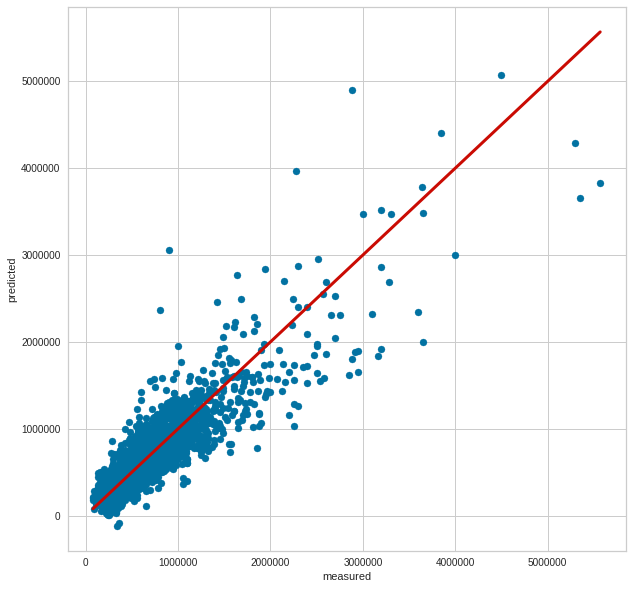

In [50]:
error, predict, score = regression_linear_function(X_poly_train, X_poly_test, y_train, y_test)
print(error)
print(score)
graph(y_test, predict)

72493.99884462568
0.8655504759572721


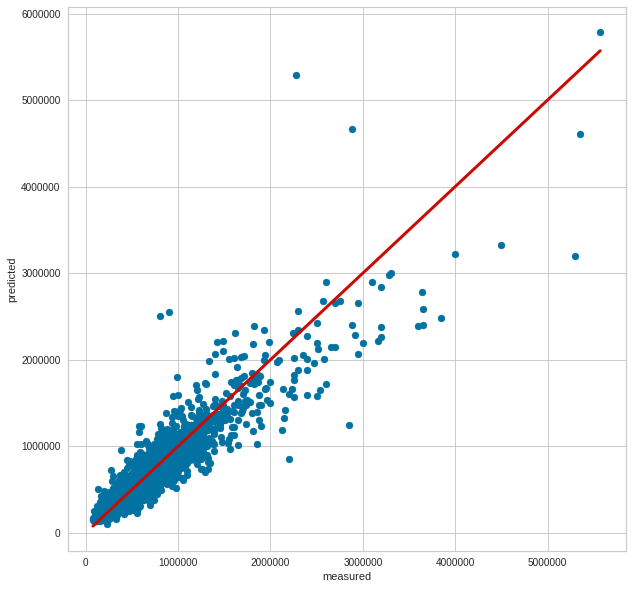

In [51]:
X_train, X_test, y_train, y_test = split(X,y, 0.25, 42)
error, predict, score = random_forest_function(X_train, X_test, y_train, y_test)
print(error)
print(score)
graph(y_test, predict)

In [52]:
stand_scaler = StandardScaler()
X_stand_train = stand_scaler.fit_transform(X_train)
X_stand_test = stand_scaler.fit_transform(X_test)
y_stand_train = stand_scaler.fit_transform(np.array(y_train).reshape(-1,1))
y_stand_test  = stand_scaler.fit_transform(np.array(y_test).reshape(-1,1))

87430.03580668836
0.7594439701958449


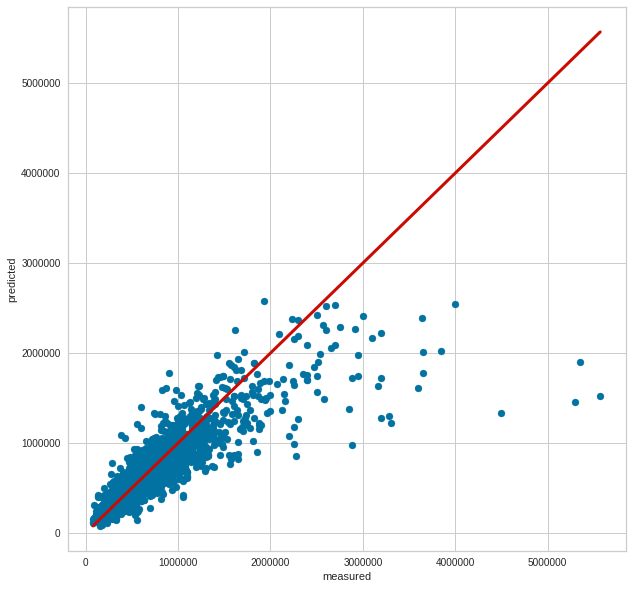

In [53]:
error, predict, score = svr_function(X_stand_train, X_stand_test, y_stand_train, y_stand_test, stand_scaler)
print(error)
print(score)
graph(stand_scaler.inverse_transform(y_stand_test), stand_scaler.inverse_transform(predict))

76787.81825604058
0.8746390127191109


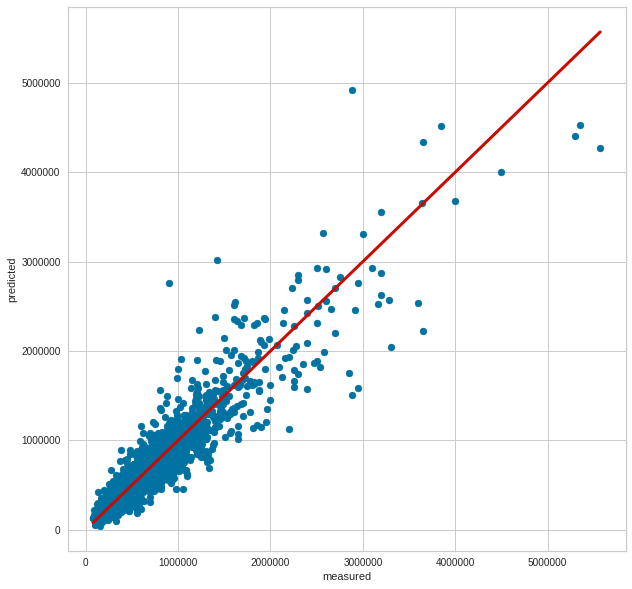

In [54]:
error, predict, score = neural_network(1000,48,24,X_stand_train, X_stand_test, y_stand_train, y_stand_test, stand_scaler)
print(error)
print(score)
graph(stand_scaler.inverse_transform(y_stand_test), stand_scaler.inverse_transform(predict))

75573.40028868274
0.8571583691368556


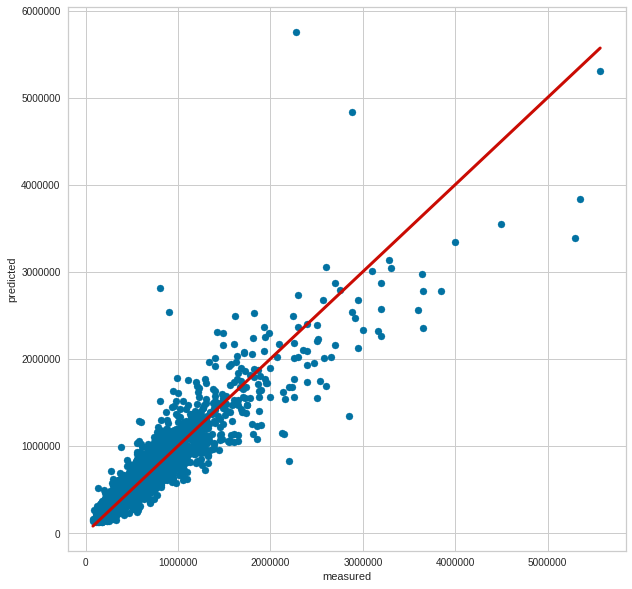

In [55]:
error, predict, score = random_forest_function(X_stand_train, X_stand_test, y_stand_train.ravel(), y_stand_test.ravel(), stand_scaler)
print(error)
print(score)
graph(stand_scaler.inverse_transform(y_stand_test), stand_scaler.inverse_transform(predict))

TESTE FINAL


In [56]:
X = df_houses.iloc[:, 1:len(df_houses.columns)]
y = df_houses.iloc[:, 0]

In [57]:
X['basement_yes'] = ''
X['basement_no'] = ''
X['water_front_yes'] = ''
X['water_front_no'] = ''
X['yr_renovated_yes'] = ''
X['yr_renovated_no'] = ''

In [58]:
# X['basement_yes'] = X[X['sqft_basement'] != 0]['sqft_basement']

# X['basement_yes'].fillna(0, inplace=True)

In [59]:
# X[X['basement_yes'] > 0] = 1

In [60]:
X.loc[X.sqft_basement > 0, 'basement_yes'] = 1
X.loc[X.sqft_basement == 0, 'basement_yes'] = 0
X.loc[X.sqft_basement > 0, 'basement_no'] = 0
X.loc[X.sqft_basement == 0, 'basement_no'] = 1

X.loc[X.waterfront > 0, 'water_front_yes'] = 1
X.loc[X.waterfront == 0, 'water_front_yes'] = 0
X.loc[X.waterfront > 0, 'water_front_no'] = 0
X.loc[X.waterfront == 0, 'water_front_no'] = 1

X.loc[X.yr_renovated > 0, 'yr_renovated_yes'] = 1
X.loc[X.yr_renovated == 0, 'yr_renovated_yes'] = 0
X.loc[X.yr_renovated > 0, 'yr_renovated_no'] = 0
X.loc[X.yr_renovated == 0, 'yr_renovated_no'] = 1


In [61]:
X

bedrooms  bathrooms  ...  yr_renovated_yes  yr_renovated_no
0             3      1.000  ...                 0                1
1             3      2.250  ...                 1                0
2             2      1.000  ...                 0                1
3             4      3.000  ...                 0                1
4             3      2.000  ...                 0                1
...         ...        ...  ...               ...              ...
21608         3      2.500  ...                 0                1
21609         4      2.500  ...                 0                1
21610         2      0.750  ...                 0                1
21611         3      2.500  ...                 0                1
21612         2      0.750  ...                 0                1

[21613 rows x 22 columns]

In [62]:
X.drop(['waterfront', 'yr_renovated', 'sqft_basement'], axis=1, inplace=True)

In [63]:
X

bedrooms  bathrooms  ...  yr_renovated_yes  yr_renovated_no
0             3      1.000  ...                 0                1
1             3      2.250  ...                 1                0
2             2      1.000  ...                 0                1
3             4      3.000  ...                 0                1
4             3      2.000  ...                 0                1
...         ...        ...  ...               ...              ...
21608         3      2.500  ...                 0                1
21609         4      2.500  ...                 0                1
21610         2      0.750  ...                 0                1
21611         3      2.500  ...                 0                1
21612         2      0.750  ...                 0                1

[21613 rows x 19 columns]

71973.84598674679
0.8650498359926091


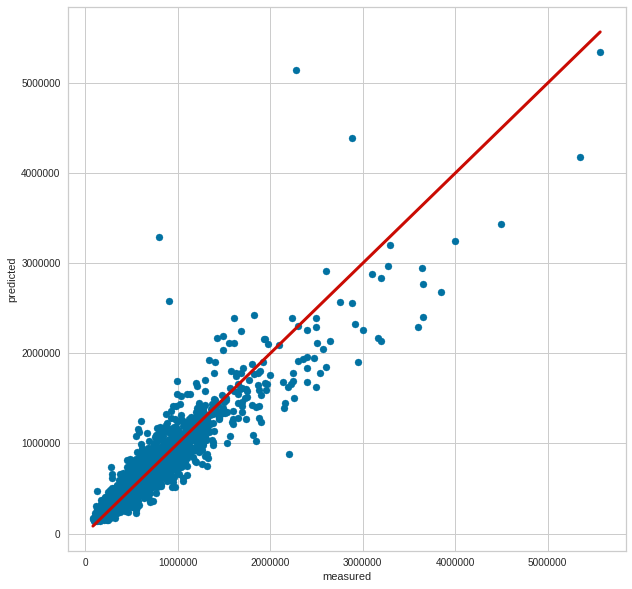

In [64]:
X_train, X_test, y_train, y_test = split(X,y, 0.2, 42)
error, predict, score = random_forest_function(X_train, X_test, y_train, y_test)
print(error)
print(score)
graph(y_test, predict)

In [65]:
stand_scaler = StandardScaler()
X_stand_train = stand_scaler.fit_transform(X_train)
X_stand_test = stand_scaler.fit_transform(X_test)
y_stand_train = stand_scaler.fit_transform(np.array(y_train).reshape(-1,1))
y_stand_test  = stand_scaler.fit_transform(np.array(y_test).reshape(-1,1))

75862.14869627032
0.8470197493196813


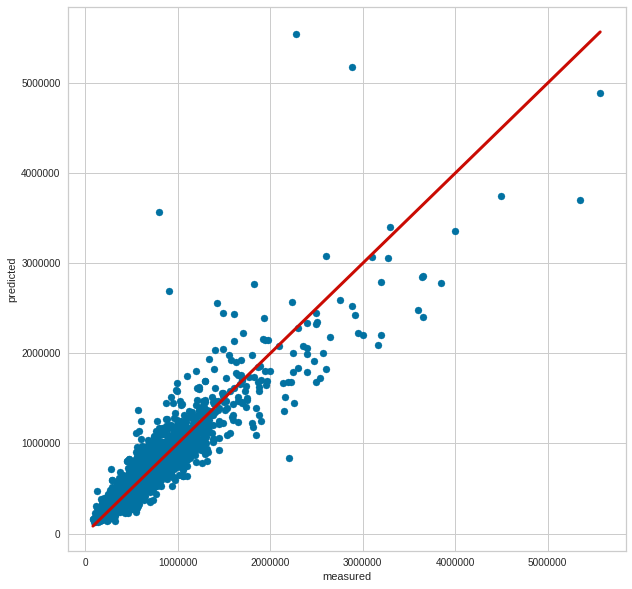

In [66]:
error, predict, score = random_forest_function(X_stand_train, X_stand_test, y_stand_train.ravel(), y_stand_test.ravel(), stand_scaler)
print(error)
print(score)
graph(stand_scaler.inverse_transform(y_stand_test), stand_scaler.inverse_transform(predict))